In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
video_path = r'AI数据样本\瓷碗出粮（3种粮）+碗内余粮+积粮\1715675377828.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count == 100:
        frame1 = frame
    if count == 4000:
        frame2 = frame
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()

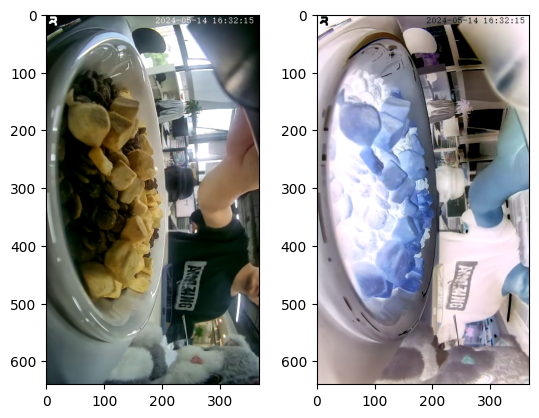

In [4]:
frame3 = np.ones_like(frame2)
for r in range(frame2.shape[0]):
    for c in range(frame2.shape[1]):
        frame3[r,c,0] = 255 - frame2[r,c,0]
        frame3[r,c,1] = 255 - frame2[r,c,1]
        frame3[r,c,2] = 255 - frame2[r,c,2]
plt.subplot(121)
plt.imshow(frame2)
plt.subplot(122)
plt.imshow(frame3)
plt.show()

In [5]:
cv2.imwrite('test3.jpg', cv2.cvtColor(frame3,cv2.COLOR_RGB2BGR))

True

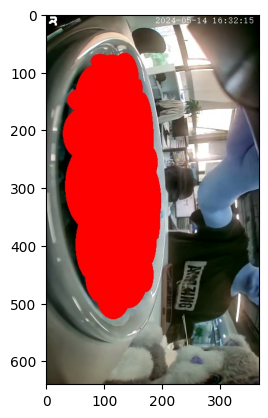

In [6]:
mask = cv2.imread("mask_red_1715675377828.jpg")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)
plt.show()

(640, 368, 3)


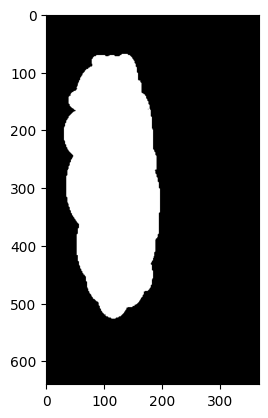

In [7]:
print(mask.shape)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i,j,0] >= 240 and mask[i,j,1] <= 10 and mask[i,j,2] <= 10:
            mask[i,j,0] = 255
            mask[i,j,1] = 255
            mask[i,j,2] = 255
            continue
        else:
            mask[i,j,0] = 0
            mask[i,j,1] = 0
            mask[i,j,2] = 0
plt.imshow(mask)
plt.show()

In [8]:
image1 = frame3
ori_image_with_mask = cv2.bitwise_and(image1, image1, mask=mask[:,:,0])

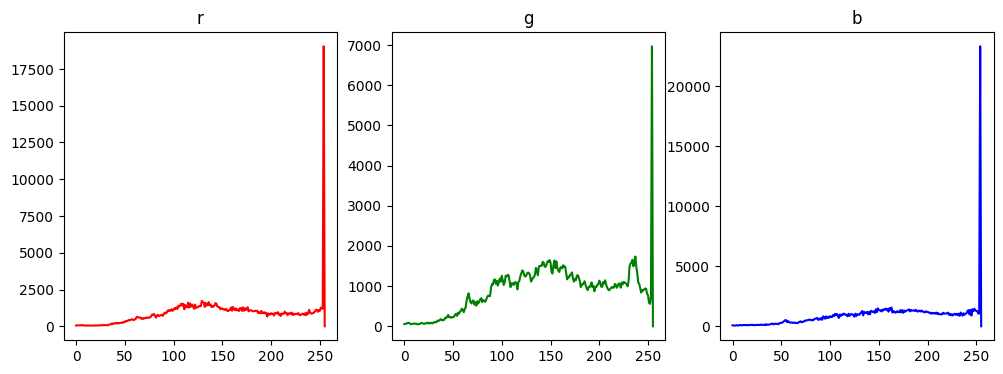

In [9]:
# plt.imshow(image1)
# plt.show()
#计算直方图（彩图）

    # 1、读取图片


    # 设置颜色通道
color = ["r", "g", "b"]
ori1 = ori_image_with_mask
    # 2、获取直方图
plt.figure(figsize=(12,4))
for i, c in enumerate(color):           #i是索引，c是内容
    hist = cv2.calcHist([image1], [i], None, [256], [1, 256])
    plt.subplot(131+i)
    plt.title(color[i])
    plt.plot(hist, color=c)
 
    # 3、直方图展示
# plt.legend(["B Channel", "G Channel", "R Channel"])     #批注
plt.show()

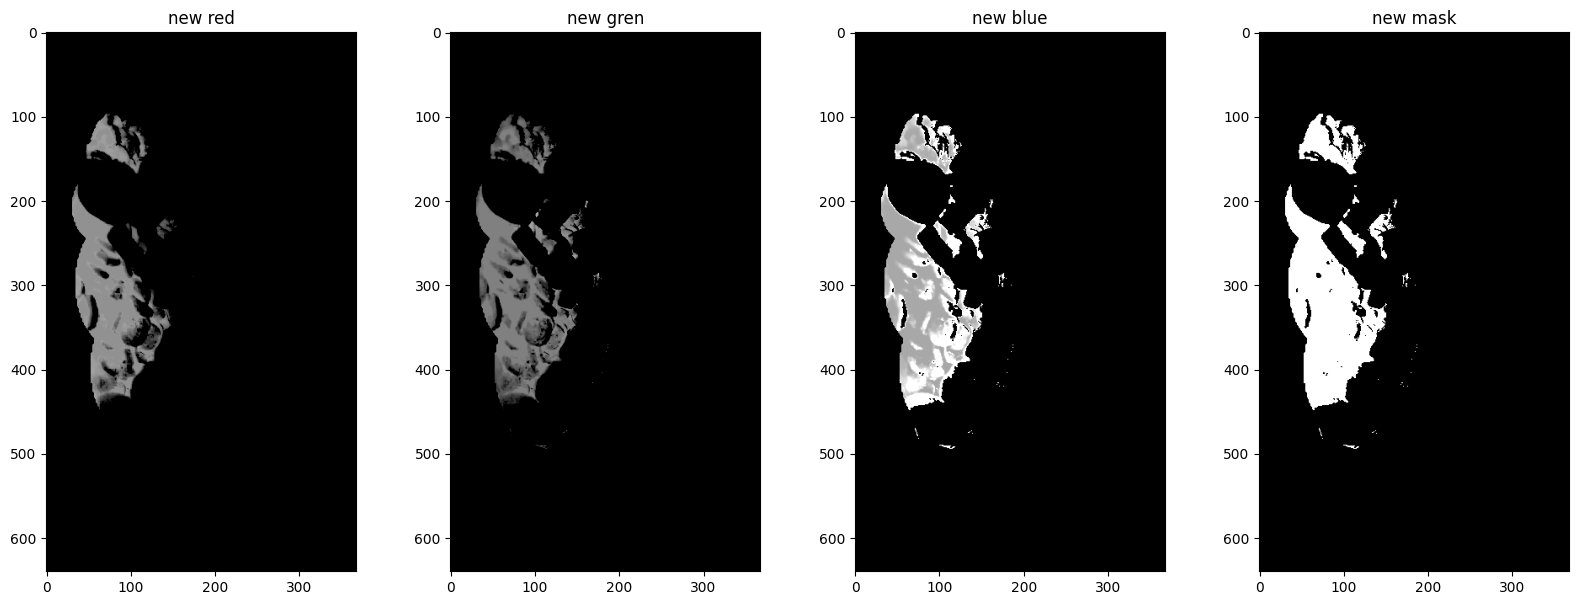

In [14]:
new_image = np.zeros_like(ori_image_with_mask)

def calculate_ratio(r, g, b):
    rr = r - 220
    rg = g - 220
    rb = b - 220
    if (rr+rg+rb)/3<0:
        return 0, 0, 0
    else:
        t = rr + rg + rb +1
        return rr/t, rg/t, rb*2/t



mask_new_image = np.zeros_like(ori_image_with_mask)
for row in range(ori_image_with_mask.shape[0]):
    for col in range(ori_image_with_mask.shape[1]):
        r, g, b = list(map(lambda x : int(x),[ori_image_with_mask[row,col,0],ori_image_with_mask[row,col,1],ori_image_with_mask[row,col,2]]))
        
        r_part = r * calculate_ratio(r, g, b)[0]
        g_part = g * calculate_ratio(r, g, b)[1]
        b_part = b * calculate_ratio(r, g, b)[2]
        new_image[row, col, 0] = max(0, min(255, int(r_part)))
        new_image[row, col, 1] = max(0, min(255, int(g_part)))
        new_image[row, col, 2] = max(0, min(255, int(b_part)))
        if max(0, min(255, int(r_part + g_part + b_part))) > 40:
            mask_new_image[row, col, 0] = 255
plt.figure(figsize=(20,7))
plt.subplot(141)
plt.imshow(new_image[:,:,0], 'gray')
plt.title('new red')
plt.subplot(142)
plt.imshow(new_image[:,:,1], 'gray')
plt.title('new gren')
plt.subplot(143)
plt.imshow(new_image[:,:,2], 'gray')
plt.title('new blue')
plt.subplot(144)
plt.imshow(mask_new_image[:,:,0], 'gray')
plt.title('new mask')
plt.show()

midval: 103.0
midval: 100.0
midval: 83.0


E:\usr\tmp\ipykernel_13324\3704136540.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


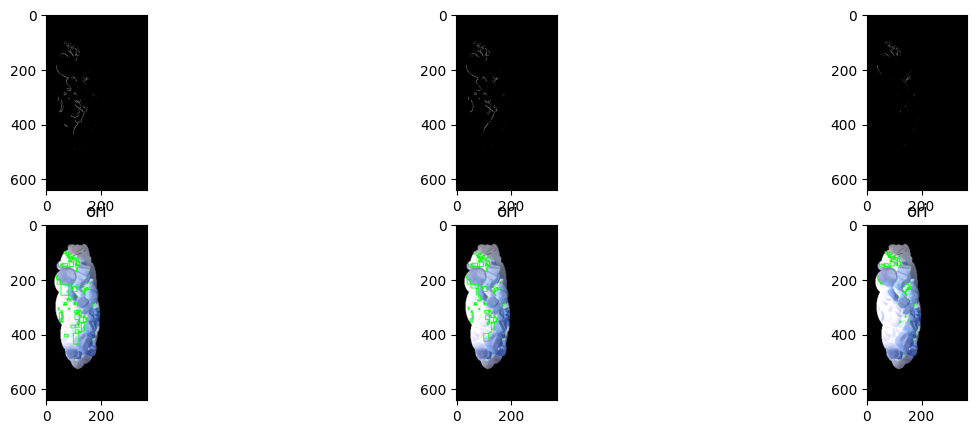

In [15]:
image1 = frame2
image1_GaussianBlur = cv2.GaussianBlur(image1, (5,5), 0)
# 求自适应阈值的最小和最大值
def GetMatMinMaxThreshold(img, sigma=0.2):

    midval = np.median(img)
    print("midval:", midval)
    # 计算低阈值
    minval = int((1.0 - sigma) * midval)
    # 计算高阈值
    maxval = int((1.0 + sigma) * midval)
    return minval ,maxval


plt.figure(figsize=(15,5))
for i in range(3):
    image_single_channel = image1_GaussianBlur[:,:,i]
    minval, maxval = GetMatMinMaxThreshold(image_single_channel)   
    Canny2_image_single_channel=cv2.Canny(image_single_channel,minval,maxval) 
    Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=mask_new_image[:,:,0])
    plt.subplot(230+i+1)
    plt.imshow(Canny2_image_single_channel, 'gray')

    contours, hierarchy = cv2.findContours(Canny2_image_single_channel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ori_image_with_mask_temp = np.copy(ori_image_with_mask)

    for c in contours:
        # 找到边界坐标
        x, y, w, h = cv2.boundingRect(c)  # 计算点集最外面的矩形边界

        small_box = ori_image_with_mask_temp[x:x+w,y:y+h,:]

        cv2.rectangle(ori_image_with_mask_temp, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # 找面积最小的矩形
        rect = cv2.minAreaRect(c)
        # 得到最小矩形的坐标
        box = cv2.boxPoints(rect)
        # 标准化坐标到整数
        box = np.int0(box)
        # 画出边界
        # cv2.drawContours(ori_image_with_mask, [box], 0, (0, 0, 255), 3)
        # 计算最小封闭圆的中心和半径
        (x, y), radius = cv2.minEnclosingCircle(c)
        # 换成整数integer
        center = (int(x),int(y))
        radius = int(radius)
        # 画圆
        # cv2.circle(ori_image_with_mask, center, radius, (0, 255, 0), 2)
    plt.subplot(230+i+4)
    plt.imshow(ori_image_with_mask_temp)
    plt.title('ori')
plt.show()


uint8 uint8


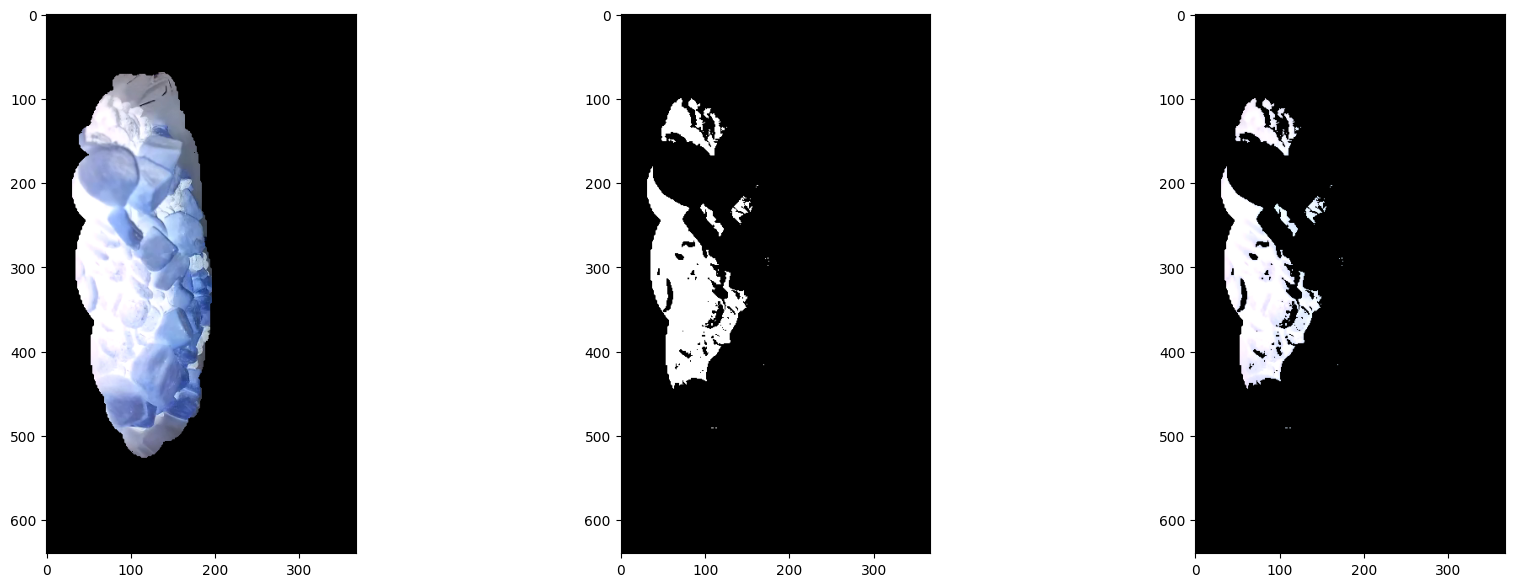

In [27]:
ori_image_std = np.copy(ori_image_with_mask)
img_sum = np.sum(ori_image_std, axis=2)
std_img = np.std(ori_image_std)

std_img = np.where(img_sum>700, 255, 0)
std_img = std_img.astype(np.uint8)
# _,std_img = cv2.threshold(std_img, 200,255,cv2.THRESH_BINARY)
print(std_img.dtype, ori_image_with_mask.dtype)
image_remove_shaddow = cv2.bitwise_and(ori_image_with_mask, ori_image_with_mask, mask=std_img)
plt.figure(figsize=(21,7))
plt.subplot(131)
plt.imshow(ori_image_with_mask)
plt.subplot(132)
plt.imshow(std_img, 'gray')
plt.subplot(133)
plt.imshow(image_remove_shaddow)
plt.show()

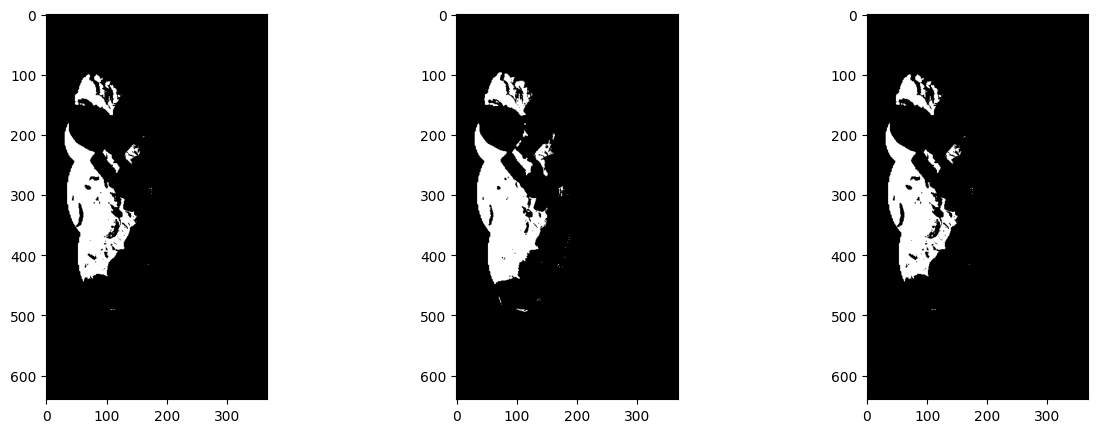

In [28]:
final_mask = np.zeros_like(mask_new_image[:,:,0])
for i in range(final_mask.shape[0]):
    for j in range(final_mask.shape[1]):
        if std_img[i,j] > 0 and mask_new_image[:,:,0][i,j]>0 :
            final_mask[i,j] = 255
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(std_img, 'gray')

plt.subplot(132)
plt.imshow(mask_new_image[:,:,0],'gray')

plt.subplot(133)
plt.imshow(final_mask, 'gray')
plt.show()

midval: 0.0
uint8
midval: 0.0
uint8


E:\usr\tmp\ipykernel_13324\4187511873.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


midval: 0.0
uint8


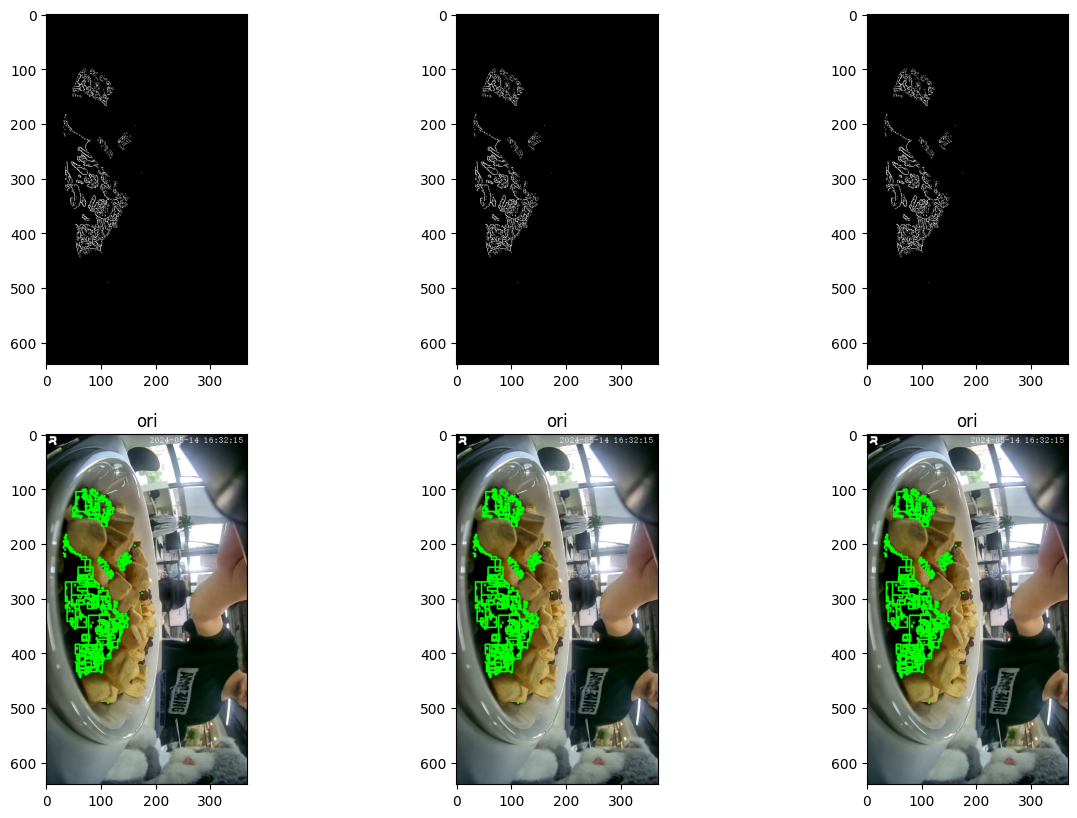

In [29]:
image1 = frame2
# image1_GaussianBlur = cv2.GaussianBlur(image1, (5,5), 0)
# 求自适应阈值的最小和最大值
def GetMatMinMaxThreshold(img, sigma=0.2):

    midval = np.median(img)
    print("midval:", midval)
    # 计算低阈值
    minval = int((1.0 - sigma) * midval)
    # 计算高阈值
    maxval = int((1.0 + sigma) * midval)
    return minval ,maxval

plt.figure(figsize=(15,10))
for i in range(3):
    image_single_channel = cv2.bitwise_and(frame2, frame2, mask=final_mask)
    minval, maxval = GetMatMinMaxThreshold(image_single_channel)   
    Canny2_image_single_channel=cv2.Canny(image_single_channel,minval,maxval) 
    print(Canny2_image_single_channel.dtype)
    Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=final_mask)
    plt.subplot(230+i+1)
    plt.imshow(Canny2_image_single_channel, 'gray')

    contours, hierarchy = cv2.findContours(Canny2_image_single_channel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ori_image_with_mask_temp = np.copy(frame2)

    for c in contours:
        # 找到边界坐标
        x, y, w, h = cv2.boundingRect(c)  # 计算点集最外面的矩形边界

        small_box = ori_image_with_mask_temp[x:x+w,y:y+h,:]

        cv2.rectangle(ori_image_with_mask_temp, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # 找面积最小的矩形
        rect = cv2.minAreaRect(c)
        # 得到最小矩形的坐标
        box = cv2.boxPoints(rect)
        # 标准化坐标到整数
        box = np.int0(box)
        # 画出边界
        # cv2.drawContours(ori_image_with_mask, [box], 0, (0, 0, 255), 3)
        # 计算最小封闭圆的中心和半径
        (x, y), radius = cv2.minEnclosingCircle(c)
        # 换成整数integer
        center = (int(x),int(y))
        radius = int(radius)
        # 画圆
        # cv2.circle(ori_image_with_mask, center, radius, (0, 255, 0), 2)
    plt.subplot(230+i+4)
    plt.imshow(ori_image_with_mask_temp)
    plt.title('ori')
plt.show()


In [110]:
def get_mask():
    mask = cv2.imread("mask_red_1715675377828.jpg")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j,0] >= 240 and mask[i,j,1] <= 10 and mask[i,j,2] <= 10:
                mask[i,j,0] = 255
                mask[i,j,1] = 255
                mask[i,j,2] = 255
                continue
            else:
                mask[i,j,0] = 0
                mask[i,j,1] = 0
                mask[i,j,2] = 0
    return mask[:,:,0]

def calculate_ratio(r, g, b):
    if b > (r - 10):
        return 0, 0
    if b > ((r+g) / 2 - 10):
        return 0, 0
    if max([r,g,b]) - min([r,g,b]) < 35:
        return 0, 0
    ratio = max(min(r - g, 17) + 3, 0) / 20
    return ratio, 1 - ratio


def get_color_mask(ori_image_with_mask):
    new_image = np.zeros_like(ori_image_with_mask)
    mask_new_image = np.zeros_like(ori_image_with_mask)
    for row in range(ori_image_with_mask.shape[0]):
        for col in range(ori_image_with_mask.shape[1]):
            r, g, b = list(map(lambda x : int(x),[ori_image_with_mask[row,col,0],ori_image_with_mask[row,col,1],ori_image_with_mask[row,col,2]]))
            
            r_part = r * calculate_ratio(r, g, b)[0]
            g_part = g * calculate_ratio(r, g, b)[1]
            new_image[row, col, 2] = max(0, min(255, int(r_part + g_part)))
            new_image[row, col, 1] = max(0, min(255, int(g_part)))
            new_image[row, col, 0] = max(0, min(255, int(r_part)))
            if max(0, min(255, int(r_part + g_part))) > 20:
                mask_new_image[row, col, 0] = 255
    return mask_new_image[:,:,0]

def get_std_mask(ori_image_with_mask):
    ori_image_std = np.copy(ori_image_with_mask)
    ori_image_std[:,:,0] = (ori_image_std[:,:,0] * 1.2).astype(np.uint8)
    ori_image_std[:,:,1] = (ori_image_std[:,:,1] * 1.2).astype(np.uint8)
    ori_image_std[:,:,2] = (ori_image_std[:,:,2] * 0.6).astype(np.uint8)
    img_sum = np.sum(ori_image_std, axis=2)
    std_img = np.std(ori_image_std, axis=2)
    print(std_img.shape)
    std_img = np.where(std_img<3, 0, 255)
    std_img = std_img.astype(np.uint8)
    return std_img

def get_final_mask(mask_new_image, std_img):
    final_mask = np.zeros_like(mask_new_image)
    for i in range(final_mask.shape[0]):
        for j in range(final_mask.shape[1]):
            if std_img[i,j] > 0 and mask_new_image[i,j]>0 :
                final_mask[i,j] = 255
    return final_mask




In [111]:
np.std(frame2, axis=2).mean()

10.867311913170715

(640, 368)


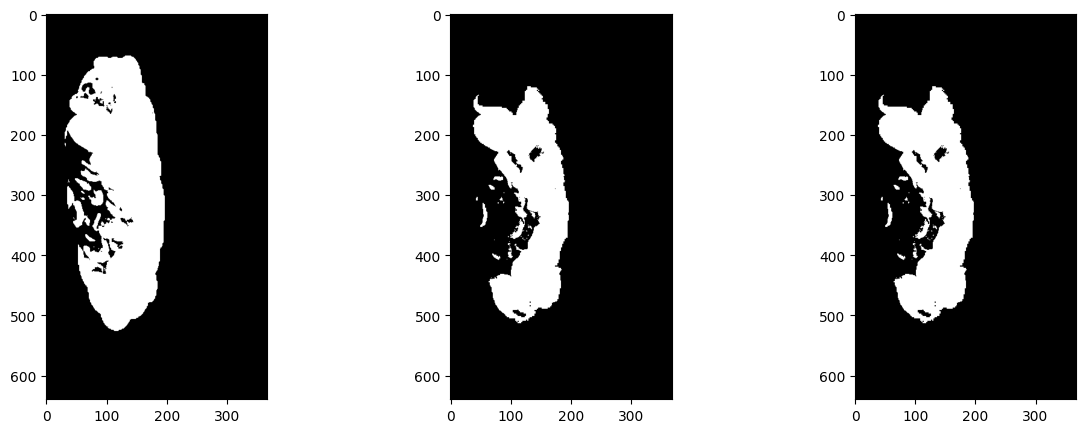

In [112]:
image = frame2
bowl_mask = get_mask()
frame_after_bowl_mask = cv2.bitwise_and(image, image, mask=bowl_mask)

std_mask = get_std_mask(frame_after_bowl_mask)
color_mask = get_color_mask(frame_after_bowl_mask)
final_mask = get_final_mask(std_mask, color_mask)
# rect_frame = get_rect_image(frame_after_bowl_mask, final_mask)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(std_mask,'gray')
plt.subplot(142)
plt.imshow(color_mask,'gray')
plt.subplot(143)
plt.imshow(final_mask,'gray')
# plt.subplot(144)
# plt.imshow(rect_frame)
plt.show()

In [60]:


# 求自适应阈值的最小和最大值
def GetMatMinMaxThreshold(img, sigma=0.2):
    midval = np.median(img)
    # 计算低阈值
    minval = int((1.0 - sigma) * midval)
    # 计算高阈值
    maxval = int((1.0 + sigma) * midval)
    return minval ,maxval

def get_rect_image(image1, final_mask, rgb=0):
    image1_GaussianBlur = cv2.GaussianBlur(image1, (5,5), 0)
    image1_GaussianBlur = cv2.GaussianBlur(image1_GaussianBlur, (5,5), 0)

    i = rgb
    image_single_channel = image1_GaussianBlur[:,:,i]
    minval, maxval = GetMatMinMaxThreshold(image_single_channel)   
    Canny2_image_single_channel=cv2.Canny(image_single_channel,minval,maxval) 
    # Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=mask_new_image[:,:,0])
    
    # Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=std_img)
    Canny2_image_single_channel = cv2.bitwise_and(Canny2_image_single_channel, Canny2_image_single_channel, mask=final_mask)
    contours, hierarchy = cv2.findContours(Canny2_image_single_channel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ori_image_with_mask_temp = np.copy(image1)

    for c in contours:
        # 找到边界坐标
        x, y, w, h = cv2.boundingRect(c)  # 计算点集最外面的矩形边界
        cv2.rectangle(ori_image_with_mask_temp, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return ori_image_with_mask_temp


In [52]:
bowl_mask = get_mask()
def get_cat_food(frame, cvt=True):
    global bowl_mask
    image = frame
    if cvt:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape, bowl_mask.shape)
    frame_after_bowl_mask = cv2.bitwise_and(image, image, mask=bowl_mask)
    # plt.imshow(frame_after_bowl_mask)
    # plt.show()

    std_mask = get_std_mask(frame_after_bowl_mask)
    color_mask = get_color_mask(frame_after_bowl_mask)
    final_mask = get_final_mask(color_mask, std_mask)
    rect_frame = get_rect_image(frame_after_bowl_mask, final_mask)
    return rect_frame


(640, 368, 3) (640, 368)


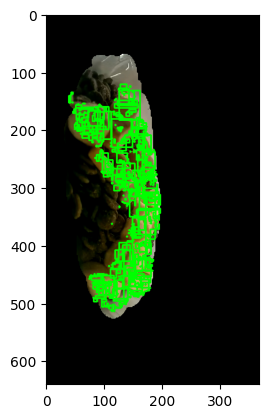

In [53]:
temp_frame = get_cat_food(frame2, False)
plt.imshow(temp_frame)
plt.show()

In [54]:
frame_list = []
ori_frame_list = []
video_path = r'1715675377828.mp4'
capture = cv2.VideoCapture(video_path)
count = 0
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    elif count % 50 != 0:
        continue
    elif frame is not None:
        print(count)
        frame_list.append(get_cat_food(frame))
        ori_frame_list.append(frame)
capture.release()

50
(640, 368, 3) (640, 368)
100
(640, 368, 3) (640, 368)
150
(640, 368, 3) (640, 368)
200
(640, 368, 3) (640, 368)
250
(640, 368, 3) (640, 368)
300
(640, 368, 3) (640, 368)
350
(640, 368, 3) (640, 368)
400
(640, 368, 3) (640, 368)
450
(640, 368, 3) (640, 368)
500
(640, 368, 3) (640, 368)
550
(640, 368, 3) (640, 368)
600
(640, 368, 3) (640, 368)
650
(640, 368, 3) (640, 368)
700
(640, 368, 3) (640, 368)
750
(640, 368, 3) (640, 368)
800
(640, 368, 3) (640, 368)
850
(640, 368, 3) (640, 368)
900
(640, 368, 3) (640, 368)
950
(640, 368, 3) (640, 368)
1000
(640, 368, 3) (640, 368)
1050
(640, 368, 3) (640, 368)
1100
(640, 368, 3) (640, 368)
1150
(640, 368, 3) (640, 368)
1200
(640, 368, 3) (640, 368)
1250
(640, 368, 3) (640, 368)
1300
(640, 368, 3) (640, 368)
1350
(640, 368, 3) (640, 368)
1400
(640, 368, 3) (640, 368)
1450
(640, 368, 3) (640, 368)
1500
(640, 368, 3) (640, 368)
1550
(640, 368, 3) (640, 368)
1600
(640, 368, 3) (640, 368)
1650
(640, 368, 3) (640, 368)
1700
(640, 368, 3) (640, 368)


In [53]:
frame_list = []
ori_frame_list = []
video_path = r'032fa596158155a8c93f8fe5747fb80f.mp4'
capture = cv2.VideoCapture(video_path)
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
capture.release()
count

10018

In [55]:
final_frame_list = []
for (a_frame,b_frame) in zip(ori_frame_list, frame_list):
    h1, w1, c1 = a_frame.shape
    h2, w2, c2 = b_frame.shape
    compare_frame = np.zeros((h1,w1+w2,3),dtype=np.uint8)
    
    compare_frame[:,:w1,:] = a_frame[:,:,:]
    compare_frame[:,w1:,:] = cv2.cvtColor(b_frame[:,:,:],cv2.COLOR_RGB2BGR)
    print(a_frame.dtype, b_frame.dtype, compare_frame.dtype)
    final_frame_list.append(compare_frame)

uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint

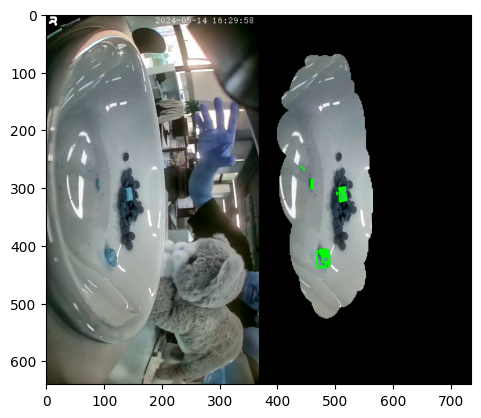

In [56]:
len(frame_list)
plt.imshow(final_frame_list[10])
plt.show()

In [57]:
video_size = (final_frame_list[0].shape[1],final_frame_list[0].shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("生成的视频2.mp4",  fourcc, 30,video_size,True)
for i in final_frame_list:
    for j in range(30):
        video.write(i)
video.release()
